<a href="https://colab.research.google.com/github/ariorzk/sibi-coral/blob/main/sibi_recognition_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIBI Alphabet Classifier for Edge TPU

This notebook contains the code to train Machine Learning model to recognize Sistem Isyarat Bahasa Indonesia (SIBI) or Indonesian sign language. The model is limited to only recognizing static alphabet of SIBI and not other kind of sign such as words, phrases, or numbers.

## Importing the dataset

For this purpose, I am using premade dataset from Kaggle titled 'Sistem Isyarat Bahasa Indonesia (SIBI)' by Alvin Bintang. This dataset contains 220 images for each static alphabets (everything except j and z) totaling 5280 images.

The codes below are intended for importing Kaggle dataset to Google Colab. If you have your own dataset or you're working on local machine with Jupyter Notebook or other applications, you can safely skip this section.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download "alvinbintang/sibi-dataset"

 99% 2.68G/2.70G [00:16<00:00, 173MB/s]
100% 2.70G/2.70G [00:16<00:00, 174MB/s]


In [ ]:
!unzip sibi-dataset.zip

In [7]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import splitfolders

splitfolders.ratio('SIBI', output="output", seed=1337, ratio=(0.8, 0.1, 0.1)) 

Copying files: 5280 files [00:11, 462.96 files/s]


## Import the needed library

In [9]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import numpy as np
import matplotlib.pyplot as plt

In [10]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

In [11]:
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 4224 images belonging to 24 classes.
Found 528 images belonging to 24 classes.
Found 528 images belonging to 24 classes.


In [12]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 24))

In [13]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('sibi_labels.txt', 'w') as f:
  f.write(labels)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [ ]:
! cat sibi_labels.txt

In [15]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                  include_top=False, 
                                                  weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=24, activation='softmax')
])

In [17]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
Total params: 2,627,448
Trainable params: 369,464
Non-tr

In [19]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


In [20]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
132/132 [==============================] - 405s 3s/step - loss: 2.7368 - accuracy: 0.1731 - val_loss: 2.1144 - val_accuracy: 0.3504
Epoch 2/10
132/132 [==============================] - 396s 3s/step - loss: 1.6462 - accuracy: 0.4801 - val_loss: 1.2132 - val_accuracy: 0.6364
Epoch 3/10
132/132 [==============================] - 399s 3s/step - loss: 0.9528 - accuracy: 0.6875 - val_loss: 0.7988 - val_accuracy: 0.7121
Epoch 4/10
132/132 [==============================] - 404s 3s/step - loss: 0.6289 - accuracy: 0.7992 - val_loss: 0.6125 - val_accuracy: 0.7992
Epoch 5/10
132/132 [==============================] - 403s 3s/step - loss: 0.4591 - accuracy: 0.8527 - val_loss: 0.4773 - val_accuracy: 0.8504
Epoch 6/10
132/132 [==============================] - 398s 3s/step - loss: 0.3396 - accuracy: 0.8949 - val_loss: 0.3900 - val_accuracy: 0.8731
Epoch 7/10
132/132 [==============================] - 401s 3s/step - loss: 0.2577 - accuracy: 0.9264 - val_loss: 0.3890 - val_accuracy: 0.8731

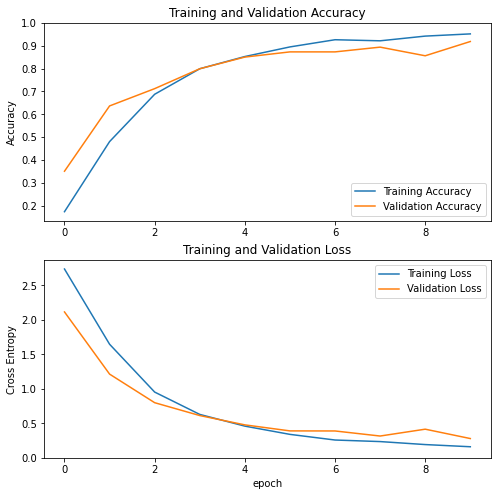

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
early_test = model.evaluate(test_generator)

17/17 [==============================] - 56s 3s/step - loss: 0.3706 - accuracy: 0.8958


In [23]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
Total params: 2,627,448
Trainable params: 2,230,904
Non-

In [26]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
132/132 [==============================] - 531s 4s/step - loss: 1.8821 - accuracy: 0.5402 - val_loss: 0.3592 - val_accuracy: 0.8883
Epoch 2/5
132/132 [==============================] - 520s 4s/step - loss: 0.8422 - accuracy: 0.7273 - val_loss: 0.3642 - val_accuracy: 0.8769
Epoch 3/5
132/132 [==============================] - 520s 4s/step - loss: 0.6076 - accuracy: 0.7983 - val_loss: 0.3560 - val_accuracy: 0.8788
Epoch 4/5
132/132 [==============================] - 520s 4s/step - loss: 0.4572 - accuracy: 0.8485 - val_loss: 0.3221 - val_accuracy: 0.8864
Epoch 5/5
132/132 [==============================] - 519s 4s/step - loss: 0.3681 - accuracy: 0.8762 - val_loss: 0.2990 - val_accuracy: 0.9053


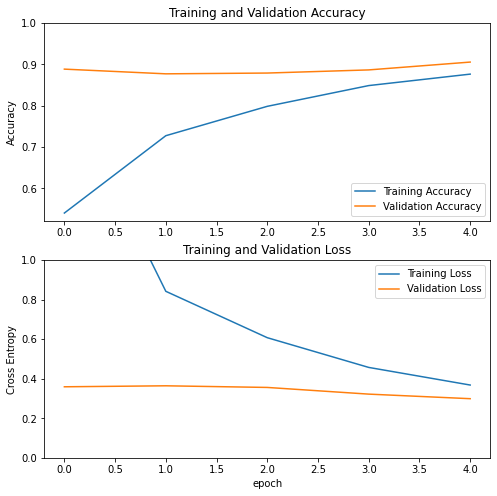

In [28]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(train_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.03_224_quant_sibi.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [30]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 90.625%


In [31]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.03_224_quant_sibi.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 78.125%


In [32]:
test = model.evaluate(test_generator)

17/17 [==============================] - 64s 4s/step - loss: 0.3815 - accuracy: 0.8845


In [33]:
pred = model.predict(test_generator)
pred = tf.nn.softmax(pred)

output = np.argmax(pred, axis=1)
labels = test_generator.class_indices
print(labels)
print(type(labels))

pred_labels = dict((v,k) for k,v in labels.items())
print(pred_labels)
print(type(pred_labels))

17/17 [==============================] - 57s 3s/step
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}
<class 'dict'>
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'}
<class 'dict'>


In [34]:
labeled_pred = []
for i in range(0, len(output)):
    labeled_pred.append(pred_labels[output[i]])

In [35]:
labeled_true = []
for i in range(0, len(test_generator.classes)):
    labeled_true.append(pred_labels[test_generator.classes[i]])

              precision    recall  f1-score   support

           A     0.8636    0.8636    0.8636        22
           B     0.9000    0.8182    0.8571        22
           C     1.0000    0.9545    0.9767        22
           D     0.9130    0.9545    0.9333        22
           E     0.8750    0.9545    0.9130        22
           F     0.8261    0.8636    0.8444        22
           G     0.8750    0.9545    0.9130        22
           H     1.0000    1.0000    1.0000        22
           I     0.9048    0.8636    0.8837        22
           K     0.5625    0.8182    0.6667        22
           L     0.9091    0.9091    0.9091        22
           M     0.9474    0.8182    0.8780        22
           N     0.8261    0.8636    0.8444        22
           O     1.0000    0.9545    0.9767        22
           P     1.0000    0.8182    0.9000        22
           Q     1.0000    1.0000    1.0000        22
           R     0.9545    0.9545    0.9545        22
           S     0.9130    

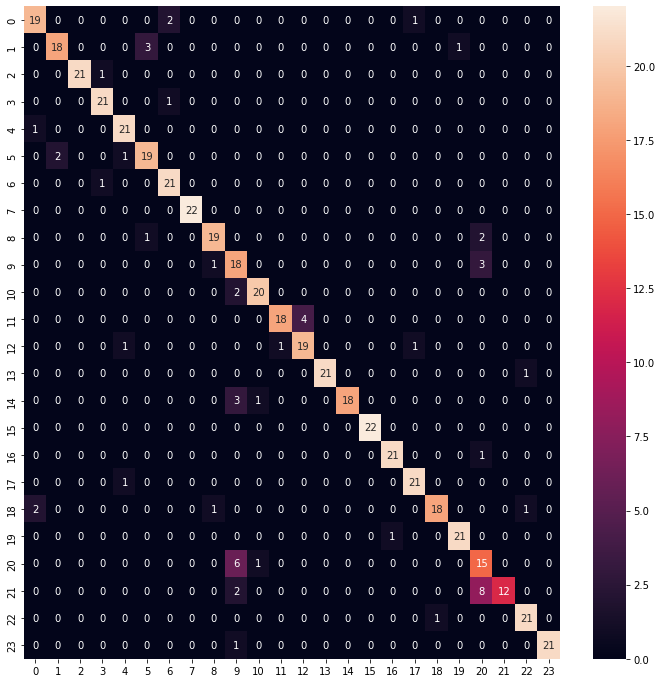

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(labeled_true,labeled_pred,digits=4))
cf_matrix = confusion_matrix(labeled_true, labeled_pred)

plt.figure(figsize=(12,12))
sns.heatmap(cf_matrix,annot=True)

In [37]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2426  100  2426    0     0  21280      0 --:--:-- --:--:-- --:--:-- 21280
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 k

In [38]:
! edgetpu_compiler mobilenet_v2_1.03_224_quant_sibi.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1253 ms.

Input model: mobilenet_v2_1.03_224_quant_sibi.tflite
Input size: 2.92MiB
Output model: mobilenet_v2_1.03_224_quant_sibi_edgetpu.tflite
Output size: 3.12MiB
On-chip memory used for caching model parameters: 3.33MiB
On-chip memory remaining for caching model parameters: 4.36MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_1.03_224_quant_sibi_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [39]:
from google.colab import files

files.download('mobilenet_v2_1.03_224_quant_sibi_edgetpu.tflite')
#files.download('sibi_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>